In [1]:
import sys
import pathlib
import os
from skmap.catalog import DataCatalog
from skmap.loader import TiledDataLoader
from skmap.overlay import SpaceOverlay, SpaceTimeOverlay
from skmap.misc import find_files, GoogleSheet, ttprint
import random
import pandas as pd
import time
import skmap_bindings as sb
import numpy as np
import geopandas as gpd
import json
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from model_fit import read_features, parameter_fine_tuning, evaluate_model, weighted_ccc, separate_data, calc_metrics
import joblib
import shap
import pickle
import matplotlib.pyplot as plt
folder_path = '/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube'

# Prepare

In [2]:
# model
model = joblib.load(f'{folder_path}/data/010_model_fine.tuned.joblib')
model.n_jobs=90

# covariates
covs = read_features(f'{folder_path}/data/008_cov_rscfi.txt')
print(f'{len(covs)} covariates')

# data
train = pd.read_parquet(f'{folder_path}/data/006_data_train.pq')
test = pd.read_parquet(f'{folder_path}/data/011_data_test.pred.pq')

# set up
cv = GroupKFold(n_splits=5) 
prop = 'ocd'
space = 'log1p'
tgt = f'{prop}_log1p'

train[tgt] = np.log1p(train[prop])
test[tgt] = np.log1p(test[prop])

model.fit(train[covs], train[tgt])
rsl = []
y_pred = model.predict(test[covs])

# rename
names = read_features(f'{folder_path}/data/014_cov.name_rscfi.txt')
name_map = dict(zip(covs,names))
rev_map = dict(zip(names,covs))

67 covariates


# Calculate Shapley values

In [3]:
# # calculate
# ttprint('start calculating shap values')
# # explainer = shap.TreeExplainer(model)
# # shaps = explainer(test[covs])

# explainer = shap.Explainer(model)
# shaps = explainer(test[covs])

# ttprint('finish calculating shap values')

# print('expected value: ',explainer.expected_value)

# with open(f'{folder_path}/data/013_shap.values_v1217', 'wb') as f:
#     pickle.dump(shaps, f)

[14:56:15] start calculating shap values
[15:46:04] finish calculating shap values
expected value:  [2.5980713]


# Static variable shap vs. dynamic variable shap

In [3]:
with open(f'{folder_path}/data/013_shap.values_v1217', 'rb') as f:
    shaps = pickle.load(f)

In [4]:
cfi = pd.read_csv(f'{folder_path}/metrics/cumulative.feature.importance_{prop}_selected.csv')

cfi['SHAP'] = np.nan
cfi['Simplified name'] = None
for fi in range(shaps.values.shape[1]):
    fn = covs[fi]
    cfi.loc[cfi['Feature Name'] == fn, 'SHAP'] = np.mean(np.abs(shaps.values[:, fi]))
    cfi.loc[cfi['Feature Name'] == fn, 'Simplified name'] = name_map.get(fn)

group_stats = cfi[['Feature Name','Group','SHAP']].groupby("Group").describe()


cfi_no_dep = cfi.loc[1::]
group_stats2 = cfi_no_dep[['Feature Name','Group','SHAP']].groupby("Group").describe()

stats = pd.concat([group_stats, group_stats2])
stats = stats.drop_duplicates()

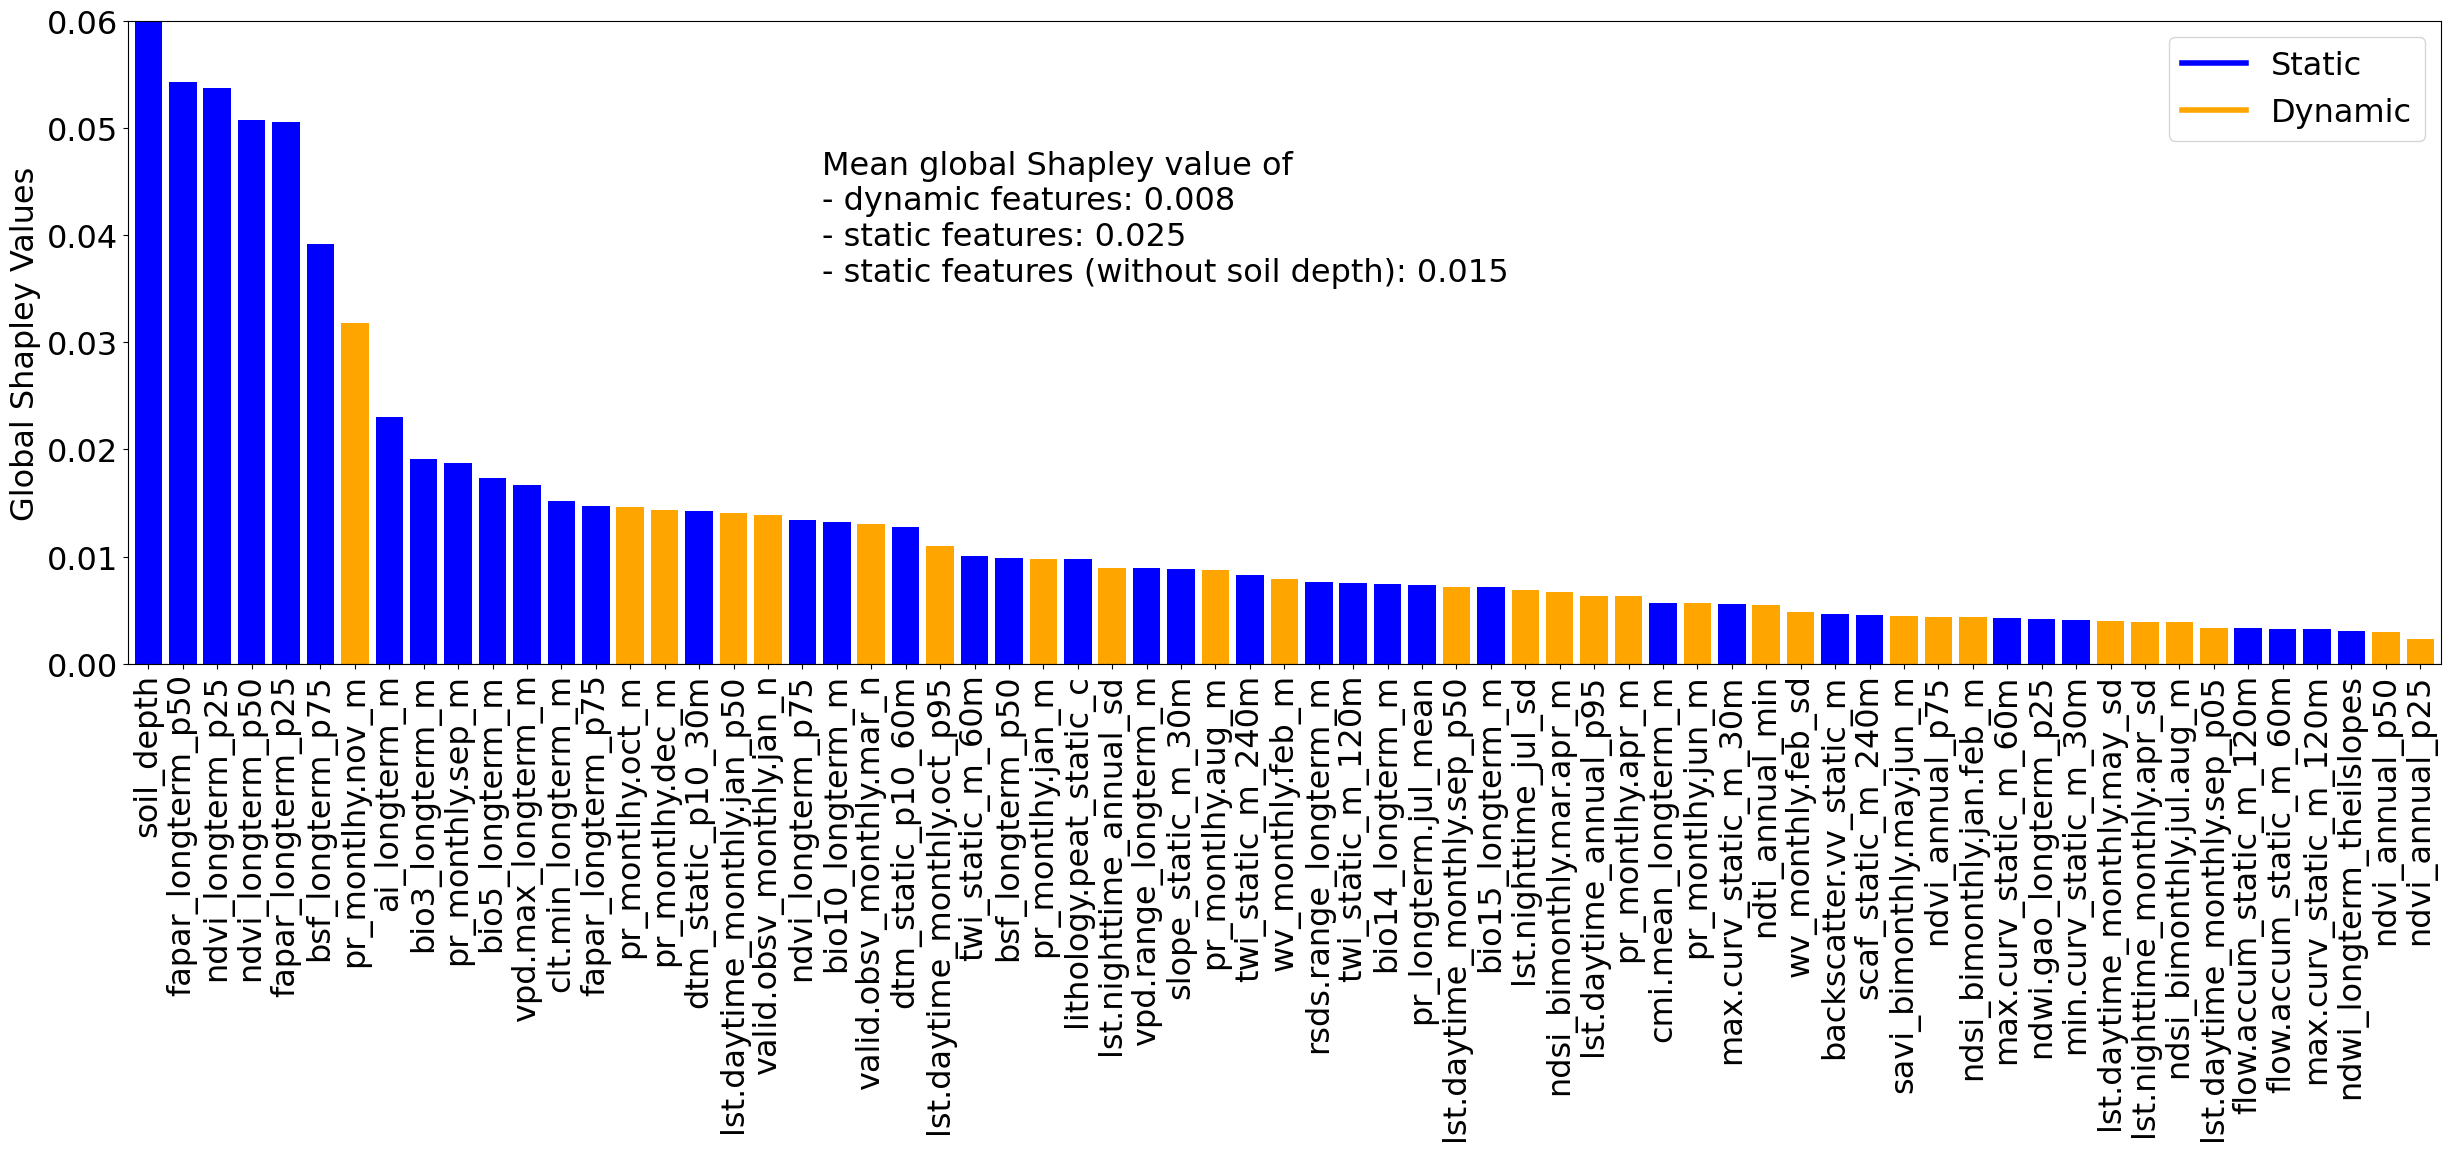

In [5]:
df_sorted = cfi.sort_values(by="SHAP", ascending=False)

plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(25, 12))

colors = df_sorted["Group"].map({"static": "blue", "dynamic": "orange"})
plt.bar(df_sorted["Simplified name"], df_sorted["SHAP"], color=colors)

plt.ylabel("Global Shapley Values")
# plt.xlabel("Features")
# plt.title("SHAP Values by Feature (Sorted)")
plt.ylim([0, 0.06])
plt.margins(x=0.003)
plt.xticks(rotation=90)
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")  # Add horizontal line at y=0
plt.legend(handles=[
    plt.Line2D([0], [0], color="blue", lw=4, label="Static"),
    plt.Line2D([0], [0], color="orange", lw=4, label="Dynamic")
])

text_str = (
    'Mean global Shapley value of\n'
    f"- dynamic features: {stats.iloc[0,1]:.3f}\n"
    f"- static features: {stats.iloc[1,1]:.3f}\n"
    f"- static features (without soil depth): {stats.iloc[2,1]:.3f}\n"
)

plt.text(
    0.3, 0.8,  # Position the text box in the top-right corner outside the plot
    text_str,
    transform=plt.gca().transAxes,  # Use axis coordinates for positioning
    verticalalignment='top'
)

plt.tight_layout()
# plt.savefig(f'{folder_path}/figure/figure_shap.dyn.sta_summary.svg', format='pdf', bbox_inches='tight', dpi=600)
plt.show()

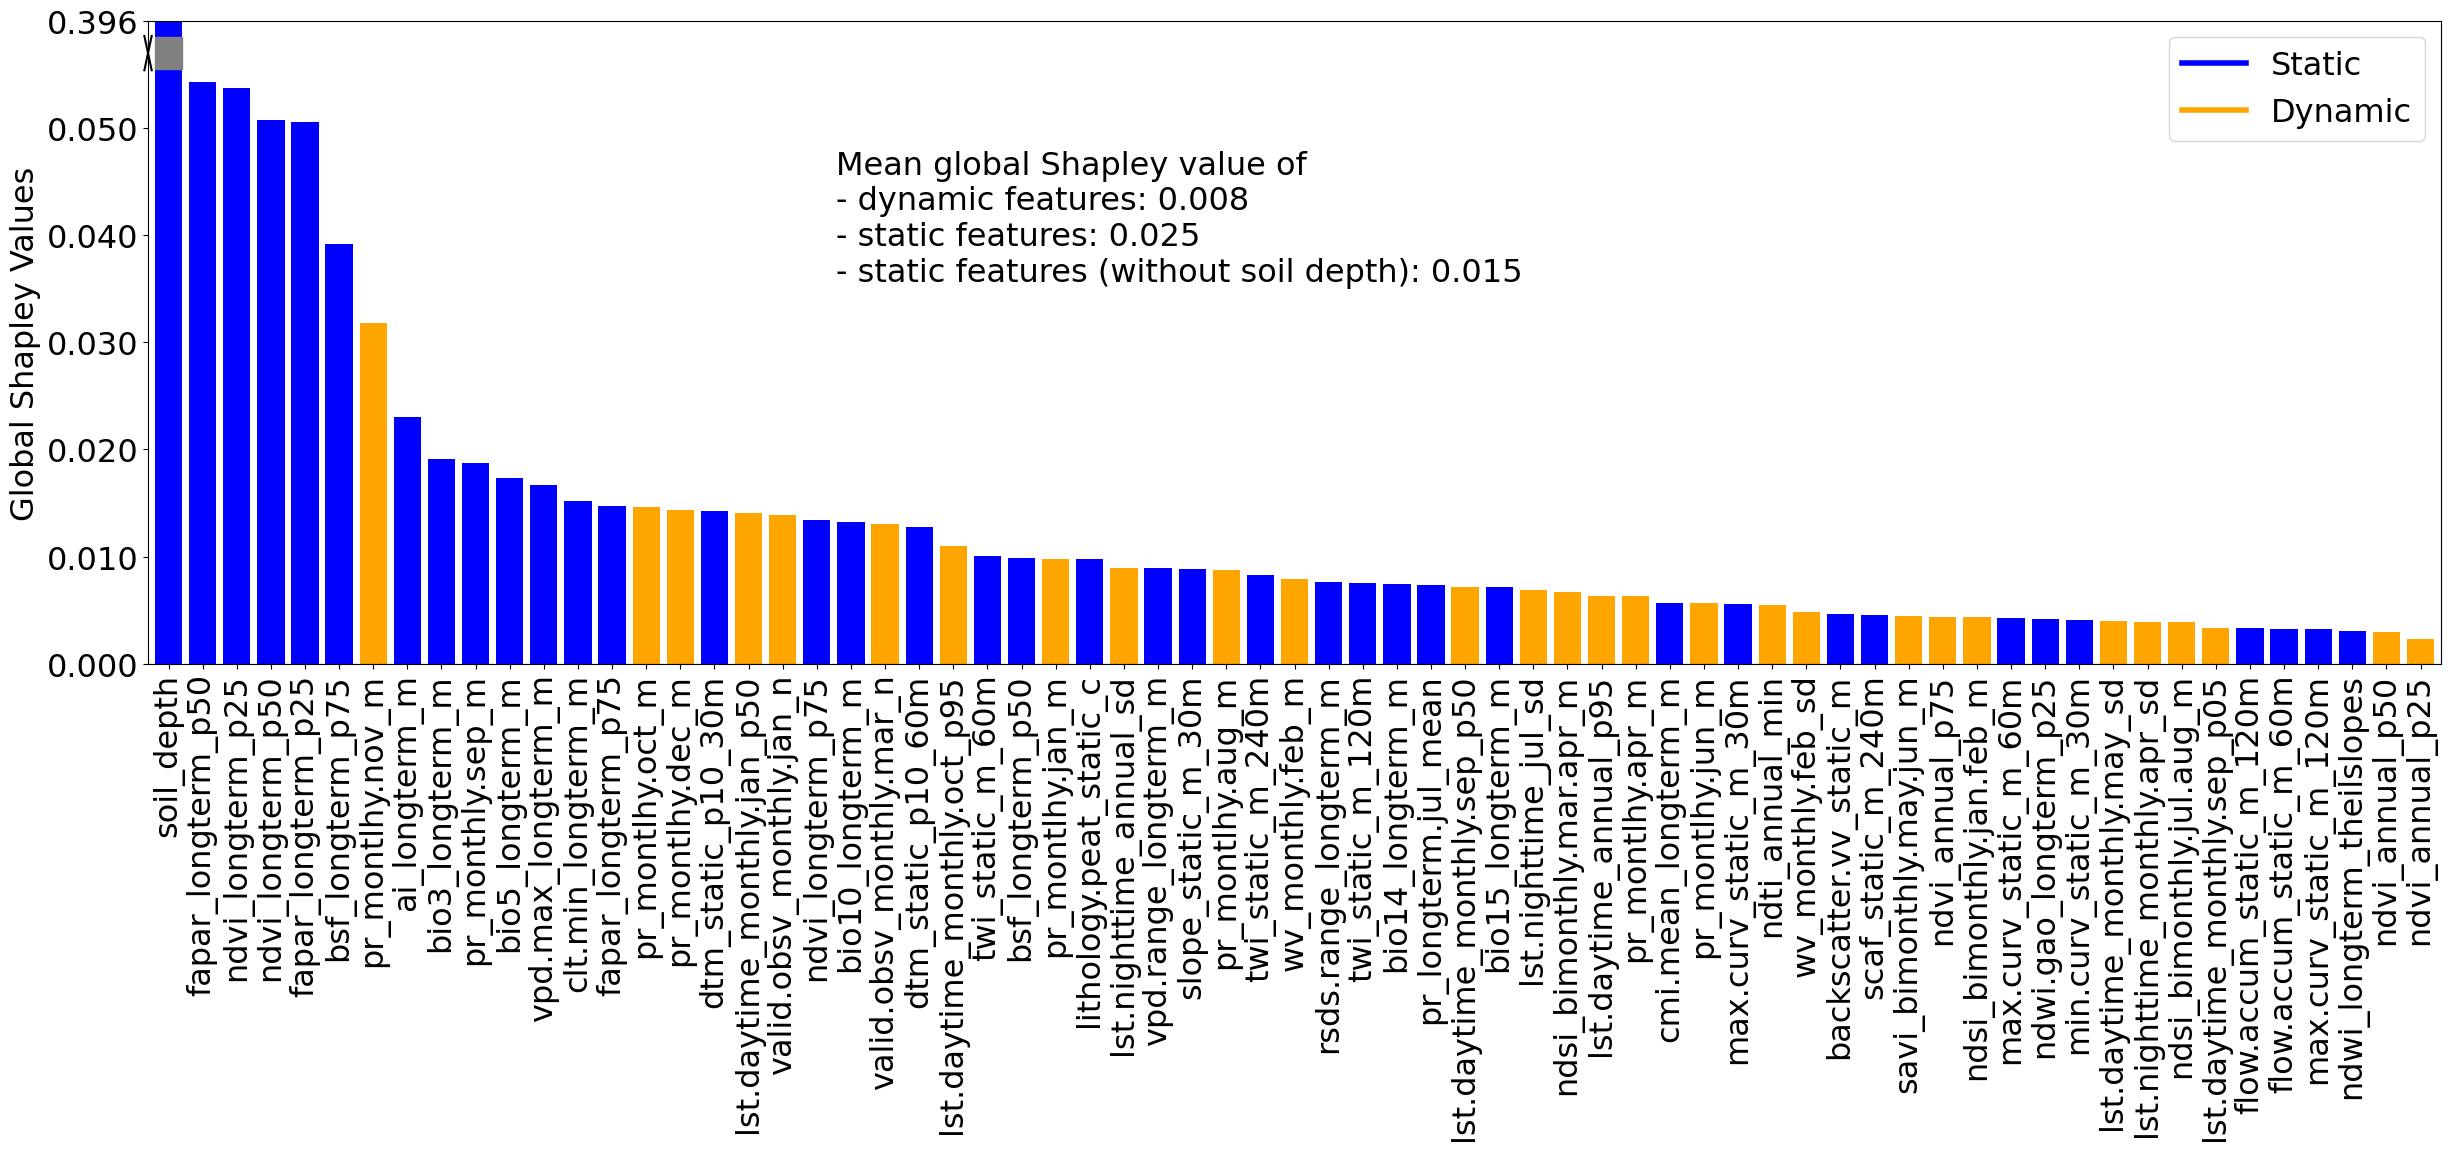

In [21]:
df_sorted = cfi.sort_values(by="SHAP", ascending=False)

from matplotlib import transforms
# Function to draw break marks
def draw_axis_break(ax, xpos, ypos, break_type='y', size=0.0016):
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData) if break_type == 'y' else transforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.plot(
        [xpos - size, xpos + size], [ypos - size, ypos + size],
        transform=trans, color='black', linewidth=1.5, clip_on=False
    )
    ax.plot(
        [xpos - size, xpos + size], [ypos + size, ypos - size],
        transform=trans, color='black', linewidth=1.5, clip_on=False
    )

    
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(25, 12))

colors = df_sorted["Group"].map({"static": "blue", "dynamic": "orange"})
plt.bar(df_sorted["Simplified name"], df_sorted["SHAP"], color=colors)

# Overlay a grey rectangle from 0.052 to 0.057 on the first bar (index 0)
first_bar_x = df_sorted.index[0]
bar_width = 0.8  # default width for plt.bar

# Get bar center position
bar_center = 0
for i, name in enumerate(df_sorted["Simplified name"]):
    if i == 0:
        bar_center = i

plt.gca().add_patch(plt.Rectangle(
    (bar_center - bar_width / 2, 0.0555),  # x, y
    bar_width,                            # width
    0.003,                                # height (0.057 - 0.052)
    color='grey',
    zorder=3
))


plt.ylabel("Global Shapley Values")
# plt.xlabel("Features")
# plt.title("SHAP Values by Feature (Sorted)")
plt.ylim([0, 0.06])
plt.margins(x=0.003)
plt.xticks(rotation=90)
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")  # Add horizontal line at y=0
plt.legend(handles=[
    plt.Line2D([0], [0], color="blue", lw=4, label="Static"),
    plt.Line2D([0], [0], color="orange", lw=4, label="Dynamic")
])

yticks = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
ytick_labels = ['0.000', '0.010', '0.020', '0.030', '0.040', '0.050', f'0.396']
plt.yticks(yticks, ytick_labels)

text_str = (
    'Mean global Shapley value of\n'
    f"- dynamic features: {stats.iloc[0,1]:.3f}\n"
    f"- static features: {stats.iloc[1,1]:.3f}\n"
    f"- static features (without soil depth): {stats.iloc[2,1]:.3f}\n"
)

plt.text(
    0.3, 0.8,  # Position the text box in the top-right corner outside the plot
    text_str,
    transform=plt.gca().transAxes,  # Use axis coordinates for positioning
    verticalalignment='top'
)

ax = plt.gca()
draw_axis_break(ax, xpos=0, ypos=0.0570, break_type='y')
# draw_axis_break(ax, xpos=0, ypos=0.0585, break_type='y')

plt.tight_layout()
plt.savefig(f'{folder_path}/figure/figure_shap.dyn.sta_summary_v20250404.pdf', format='pdf', bbox_inches='tight', dpi=600)
plt.show()

In [29]:
cfi.iloc[0]

Feature Name                             hzn_dep
Mean Cumulative Feature Importance      0.234573
Group                                     static
SHAP                                    0.396455
Simplified name                       soil_depth
Name: 0, dtype: object

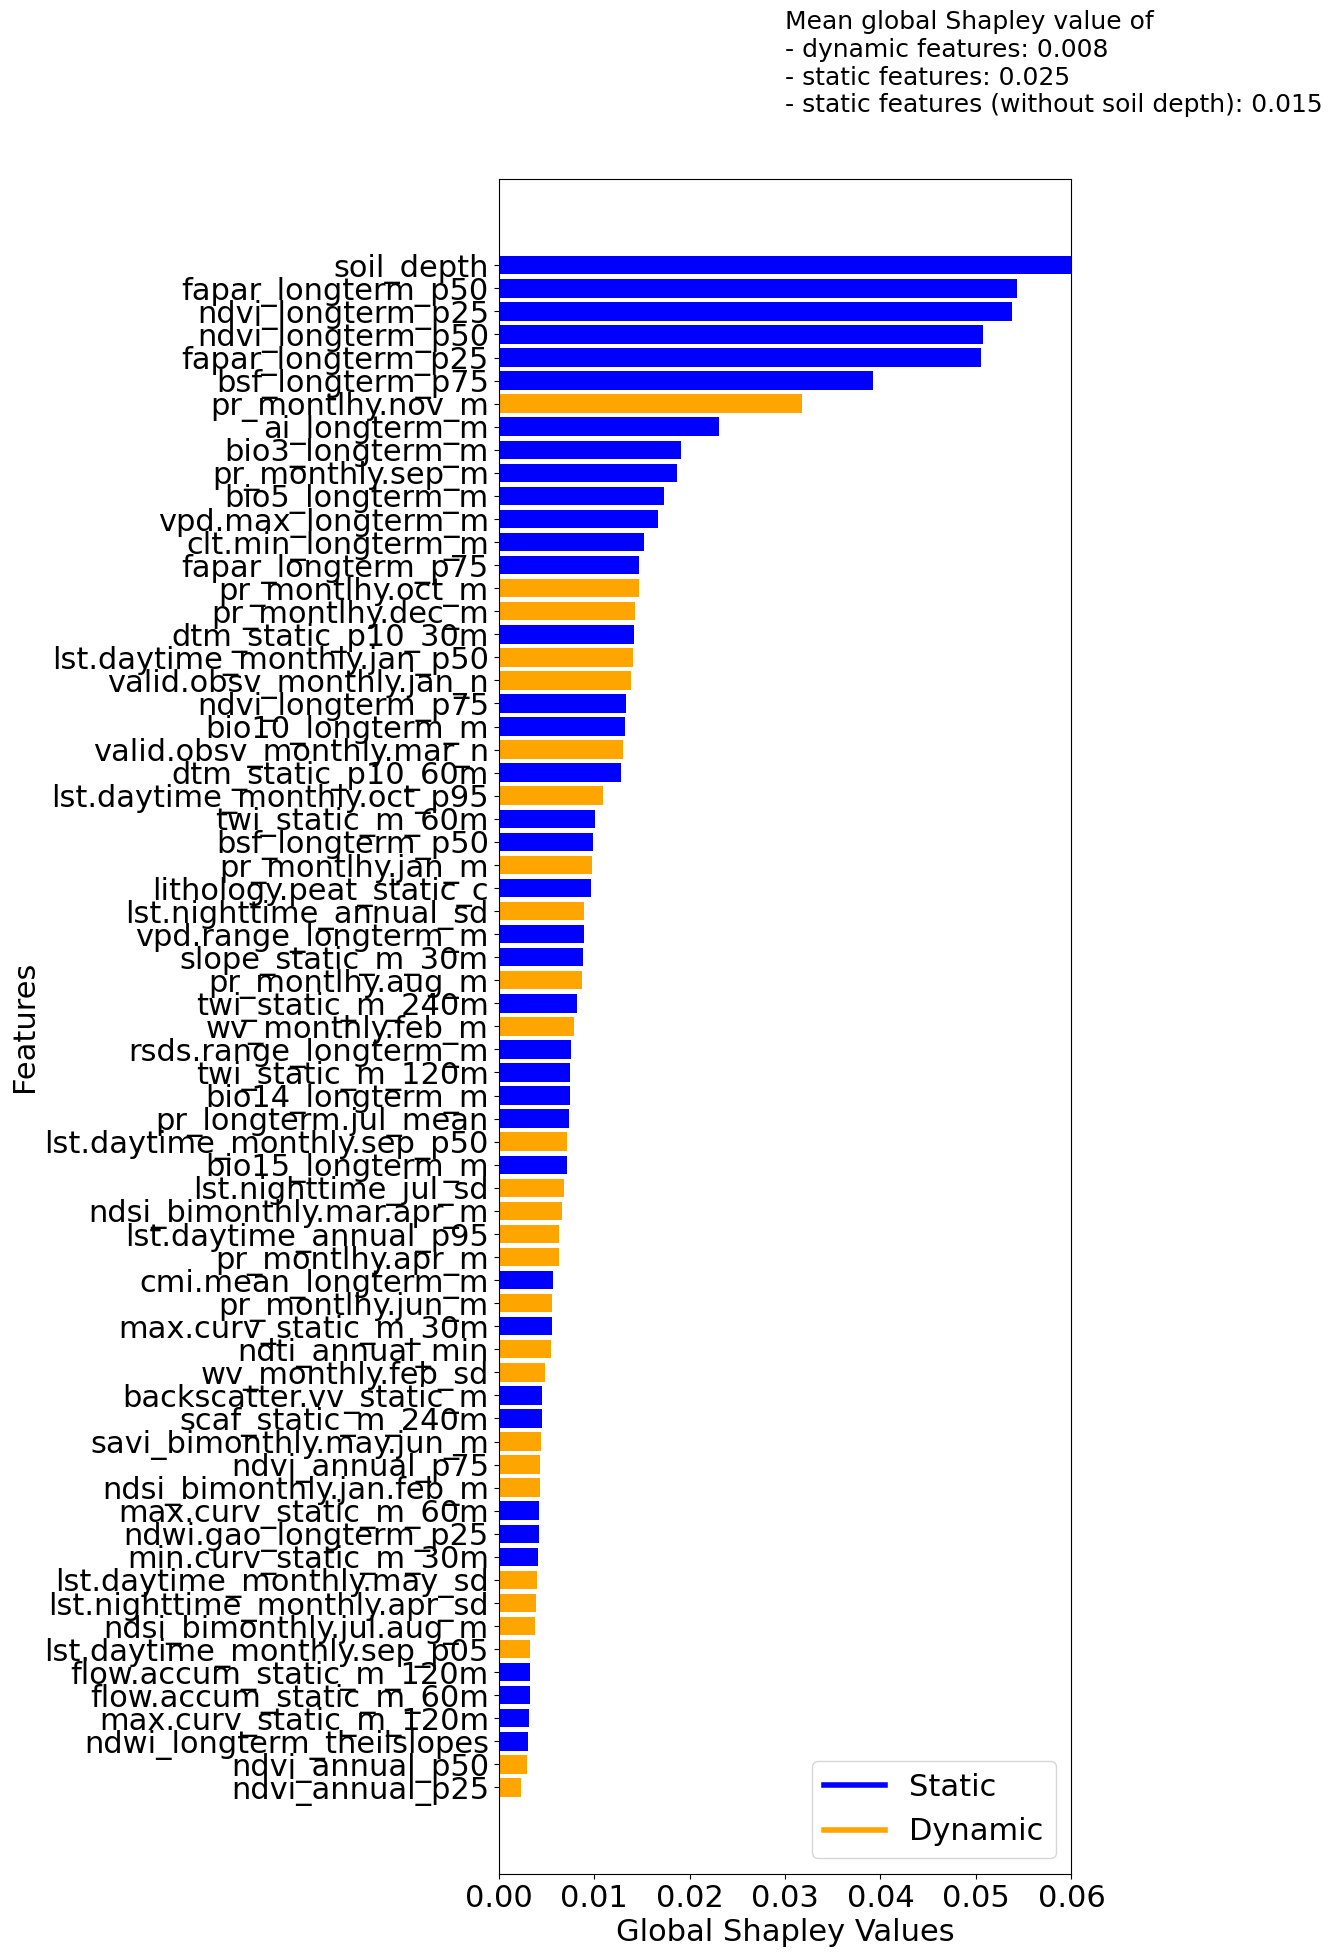

In [15]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 20))  # Adjust for vertical features

# Map colors for static and dynamic groups
colors = df_sorted["Group"].map({"static": "blue", "dynamic": "orange"})

# Horizontal bar plot
plt.barh(df_sorted["Simplified name"], df_sorted["SHAP"], color=colors)

# Add labels and styling
plt.xlabel("Global Shapley Values")
plt.ylabel("Features")
plt.xlim([0, 0.06])  # Set the x-axis range
plt.gca().invert_yaxis()  # Invert y-axis to have the largest values on top

# Add legend
plt.legend(handles=[
    plt.Line2D([0], [0], color="blue", lw=4, label="Static"),
    plt.Line2D([0], [0], color="orange", lw=4, label="Dynamic")
])

# Add summary text box
text_str = (
    'Mean global Shapley value of\n'
    f"- dynamic features: {stats.iloc[0,1]:.3f}\n"
    f"- static features: {stats.iloc[1,1]:.3f}\n"
    f"- static features (without soil depth): {stats.iloc[2,1]:.3f}\n"
)

plt.text(
    0.5, 1.02,  # Position the text box above the plot
    text_str,
    transform=plt.gca().transAxes,  # Use axis-relative positioning
    fontsize=18,
    verticalalignment='bottom'
)

# Save the figure
plt.tight_layout()
# plt.savefig(f'{folder_path}/figure/figure_shap.dyn.sta_summary.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()


# Visualization

In [6]:
# read 
with open(f'{folder_path}/data/013_shap.values_v1217', 'rb') as f:
    shaps = pickle.load(f)
    
# rename
shaps.feature_names = [name_map.get(name, name) for name in shaps.feature_names]

### global plot

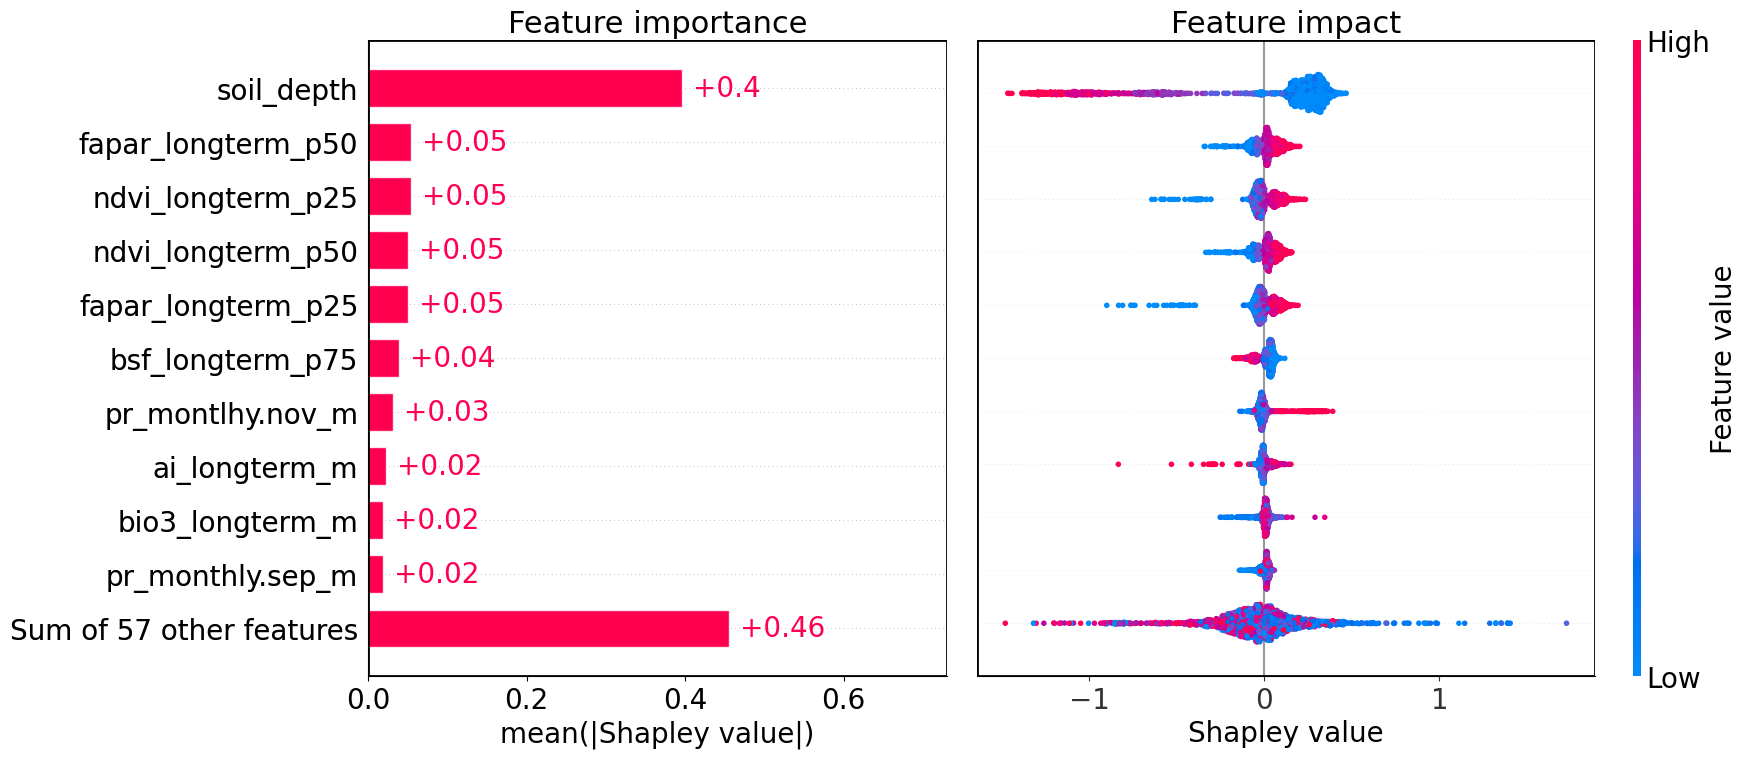

In [7]:
import shap
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

# Create a figure with GridSpec layout to control subplot sizes
fig = plt.figure()  # Increase figure size to be more spacious, figsize=(30, 10)
gs = GridSpec(1, 2, width_ratios=[3,4], figure=fig)  # Control the width ratios of the plots

# SHAP bar plot
ax1 = fig.add_subplot(gs[0])  # First subplot
plt.sca(ax1)  # Set the current axis to ax1
shap.plots.bar(shaps, max_display=11, show=False)

# Customize the bar plot
ax1.set_xlabel("mean(|Shapley value|)", fontsize=20)  # X-axis label size
ax1.set_title("Feature importance", fontsize=22)  # Title size
ax1.tick_params(axis='both', which='major', labelsize=20)  # X and Y tick size
ax1.set_xlim(0, 0.73)  # Set the x-axis limit to 0.6

for text in ax1.texts:
    text.set_fontsize(20)

# Add a frame (rectangle) around the bar plot
rect1 = patches.Rectangle((0, 0), 1, 1, transform=ax1.transAxes, linewidth=2, edgecolor='black', facecolor='none')
ax1.add_patch(rect1)

# SHAP beeswarm plot
ax2 = fig.add_subplot(gs[1])  # Second subplot
plt.sca(ax2)  # Set the current axis to ax2
shap.plots.beeswarm(shaps, max_display=11, show=False)

# Customize the beeswarm plot
ax2.set_xlabel("Shapley value", fontsize=20)  # X-axis label size
ax2.set_title("Feature impact", fontsize=22)  # Title size
ax2.tick_params(axis='both', which='major', labelsize=20)  # X and Y tick size
ax2.set_yticklabels([])  # Hide y-axis labels for the beeswarm plot

# Customize color bar label size if it exists
cbar = plt.gcf().axes[-1]  # Get the colorbar axis
cbar.set_ylabel('Feature value', fontsize=20)  # Color bar label size
cbar.tick_params(labelsize=20)  # Color bar tick size

# Add a frame (rectangle) around the beeswarm plot
rect2 = patches.Rectangle((0, 0), 1, 1, transform=ax2.transAxes, linewidth=2, edgecolor='black', facecolor='none')
ax2.add_patch(rect2)

# Adjust layout manually if needed to ensure the plot takes full advantage of the figure size
# plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1, wspace=0.4)

# Force the layout to adjust to the new figure size
fig.set_size_inches(18, 8)  # Re-set the figure size after the plots are created
fig.tight_layout(pad=1.0)    # Apply a tight layout to avoid overlaps

# Show the combined plot
plt.savefig(f'{folder_path}/figure/figure_shap.summary.pdf', format='pdf', dpi=300)

plt.show()





### PDP

In [8]:
mean_shap_values = np.abs(shaps.values).mean(axis=0)
top_10_indices = np.argsort(mean_shap_values)[-10:][::-1]
top_10_features = np.array(shaps.feature_names)[top_10_indices]

scaler = [1, 0.008, 0.008, 0.008, 0.008, 0.01, 0.1, 1, 0.1, 0.1]
offset = [0, -1, -1, -1, -1, -1, 0, 0, 0, 0]
top_10_features 

array(['soil_depth', 'fapar_longterm_p50', 'ndvi_longterm_p25',
       'ndvi_longterm_p50', 'fapar_longterm_p25', 'bsf_longterm_p75',
       'pr_montlhy.nov_m', 'ai_longterm_m', 'bio3_longterm_m',
       'pr_monthly.sep_m'], dtype='<U28')

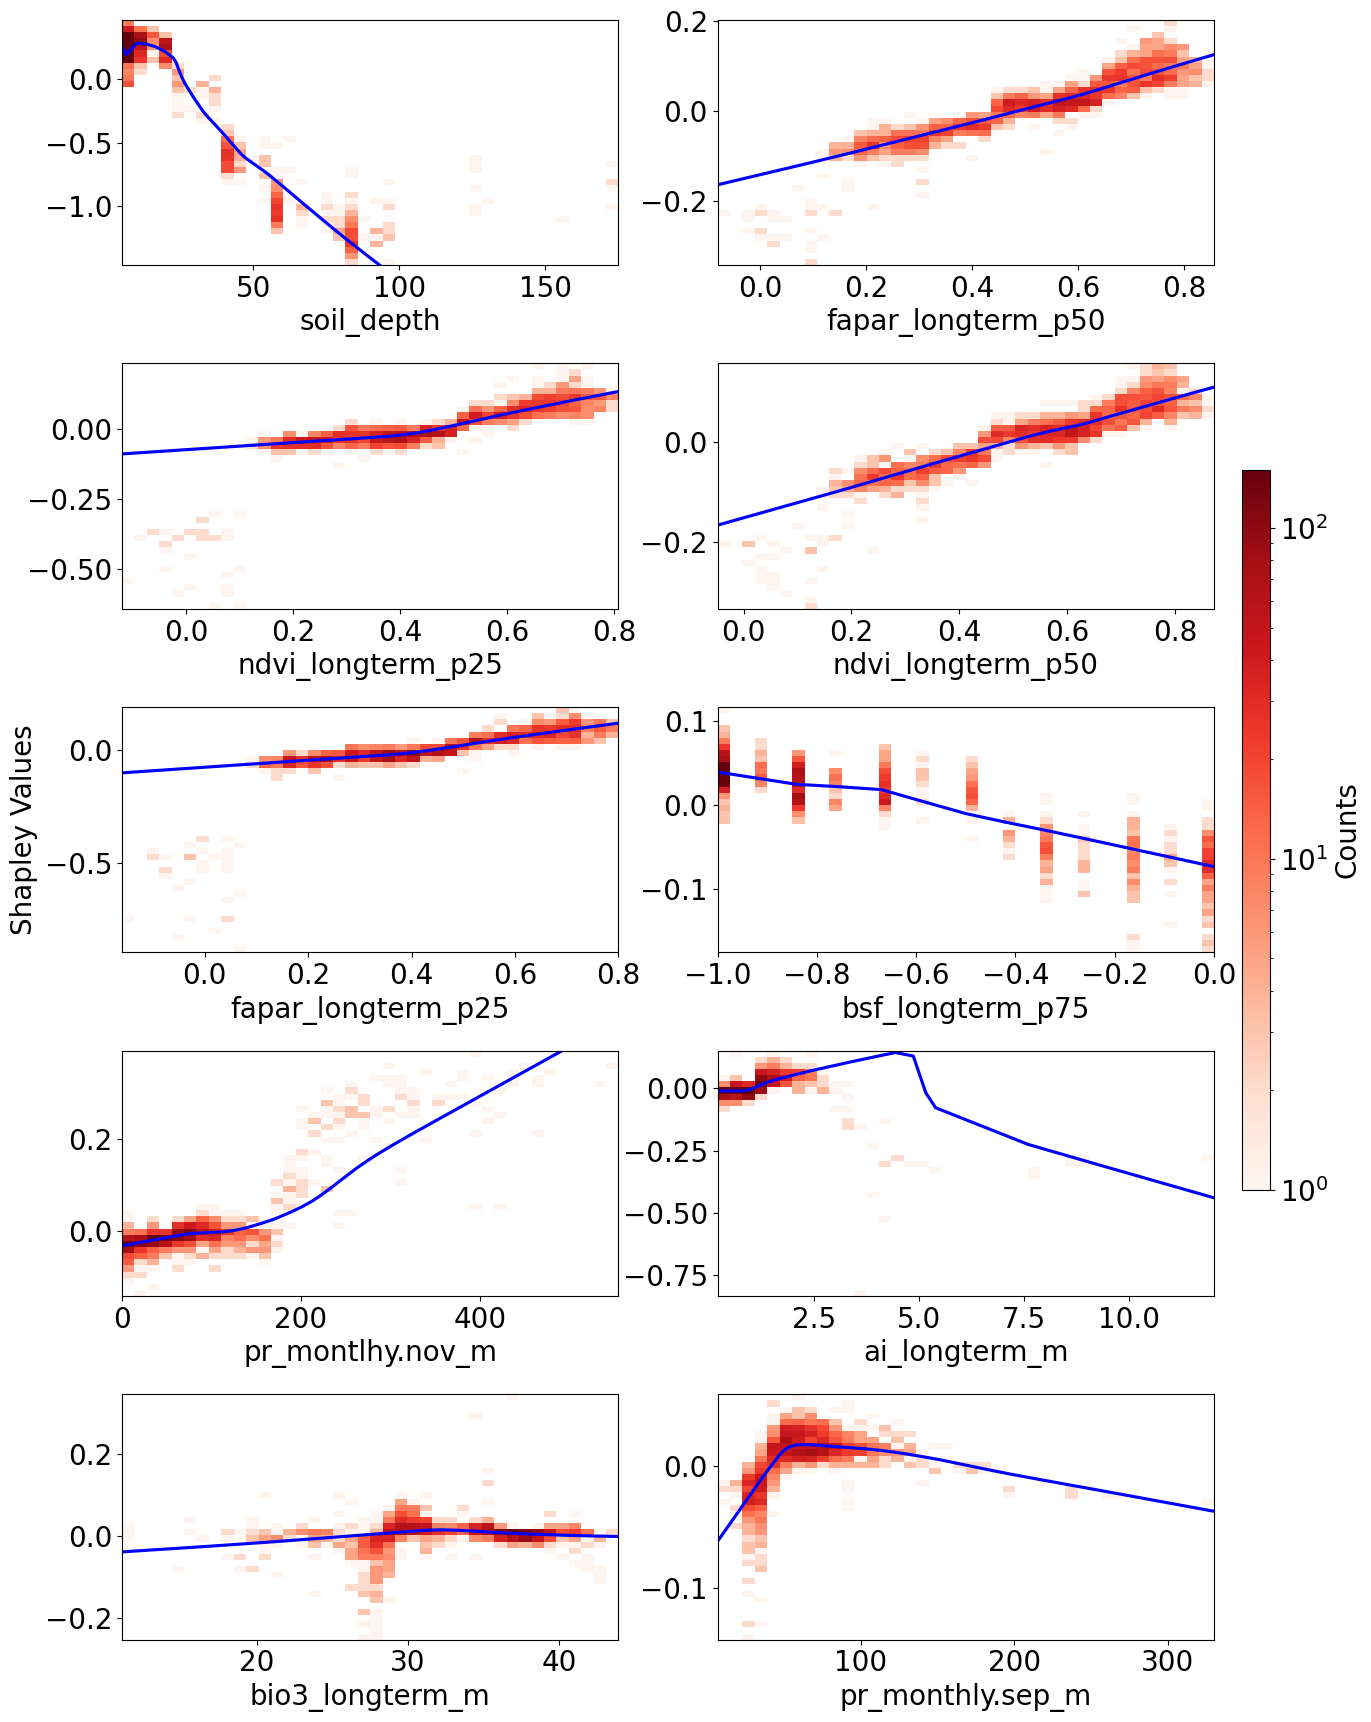

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm


# Create a figure with a grid of subplots
fig, axes = plt.subplots(5, 2, figsize=(14, 18))  # 5 rows, 2 columns

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define a common colormap and norm for all plots
cmap = 'Reds'
norm = LogNorm(vmin=1, vmax=150)  # Use LogNorm and set the limits to [1, 150]

# Iterate over the axes and plot each subplot
for i, feature in enumerate(top_10_features):
    ax = axes[i]
    
    # Get the feature values and corresponding SHAP values
    feature_f = rev_map.get(feature)
    feature_values = test[feature_f]
    shap_values = shaps.values[:, top_10_indices[i]]
    
    feature_values = feature_values*scaler[i]+offset[i]

    # Create a 2D histogram plot for density heatmap effect
    hist = ax.hist2d(feature_values, shap_values, bins=40, cmap=cmap, norm=norm)

    # Fit a lowess curve to show the trend (optional)
    sns.regplot(x=feature_values, y=shap_values, ax=ax, lowess=True, scatter=False, color='blue')

    # Set titles and labels with fontsize
    ax.set_xlabel(feature, fontsize=20)

    # Set tick parameters for both x and y axis
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)

# Add a single shared color bar on the right side
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # [left, bottom, width, height]
cb = fig.colorbar(hist[3], cax=cbar_ax, orientation='vertical')
cb.set_label('Counts', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Add a single shared y-label
fig.text(0.04, 0.5, 'Shapley Values', va='center', rotation='vertical', fontsize=20)

# Adjust the layout manually to make space for the color bar and shared y-label
plt.subplots_adjust(left=0.12, right=0.9, top=0.95, bottom=0.05, hspace=0.4)
plt.savefig(f'{folder_path}/figure/figure_shap.pdp.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()



### waterfall plot

In [10]:
test['ocd_pred'] = y_pred
test['ocd_pred_ori'] = np.expm1(test['ocd_pred'])

# sid = ['50604436', '31582170', 'RMZYIWPRXZ','2340']
sid = ['30362124','50324560'] # es cropland, fi woodland
water = test.loc[test['id'].isin(sid)]
mi = water.index.values
# water = water[['time', 'lat', 'lon', 'hzn_dep', 'id', 'ref', 'nuts0', 'lc_survey', 'ocd']]
# water['indexx'] = ['A','B']
# water.to_csv(f'{folder_path}/figure/point_waterfall.csv',index=False)
water

,time,lat,lon,hzn_dep,id,ref,nuts0,lc_survey,ocd,evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0101_YYYY0228_eu_epsg.3035_v20231127,...,lithology.81.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.3035_v20240530.tif,hillshade.bareearth_ensemble_m_30m_s_20000101_20221231_eu_epsg.3035_v20240424,slope.bareearth_ensemble_m_480m_s_20000101_20221231_eu_epsg.3035_v20240501,pet.penman.min_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531,bioclim.var_chelsa.bio18_m_1km_s_19810101_20101231_eu_epsg.3035_v20230822,tile_id,hzn_dep_bin,ocd_log1p,ocd_pred,ocd_pred_ori
635,2018,63.487120,24.312340,10.0,50324560,LUCAS,FI,woodland,62.145600,162.0,...,0.0,254.0,14.0,740.0,2547.0,1250,0-20,4.145443,4.142356,61.950986
912,2018,41.037935,-5.333642,10.0,30362124,LUCAS,ES,cropland,4.757743,151.0,...,0.0,254.0,143.0,2965.0,549.0,638,0-20,1.750546,2.249168,8.479843


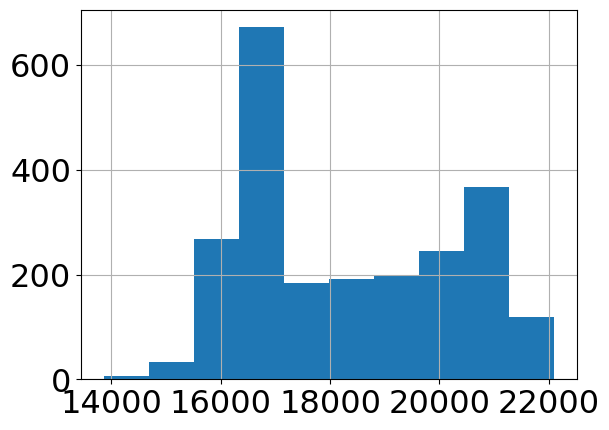

In [35]:
test['rsds.range_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531'].hist()
plt.show()

In [11]:
# min max scale
for fi in range(shaps.data.shape[1]):
    # shaps.data[:,fi]
    col_min = np.min(shaps.data[:, fi])  # Minimum value in the column
    col_max = np.max(shaps.data[:, fi])  # Maximum value in the column
    
    if 'bsf' in covs[fi]:
        scaler = 0.01
        offset = 0
    elif 'glad.lan' in covs[fi]:
        scaler = 0.008
        offset = -1
    elif 'clm_lst' in covs[fi]:
        scaler = 0.02
        offset = -273.15
    elif 'pr' in covs[fi]:
        scaler = 0.1
        offset = 0
    elif ('vpd' in covs[fi]) or ('cmi' in covs[fi]) or ('bio3' in covs[fi])  or ('bio14' in covs[fi]):
        scaler = 0.1
        offset = 0
    elif ('bio5' in covs[fi]) or ('bio10' in covs[fi]):
        scaler = 0.1
        offset = -273.15
    elif 'clt' in covs[fi]:
        scaler = 0.01
        offset = 0
    elif 'rsds' in covs[fi]:
        scaler = 0.001
        offset = 0
    else:
        scaler = 1
        offset = 0
        
    shaps.data[:, fi] = shaps.data[:, fi]*scaler + offset
    # Scale the column to [0, 1]
    # shaps.data[:, fi] = (shaps.data[:, fi] - col_min) / (col_max - col_min)

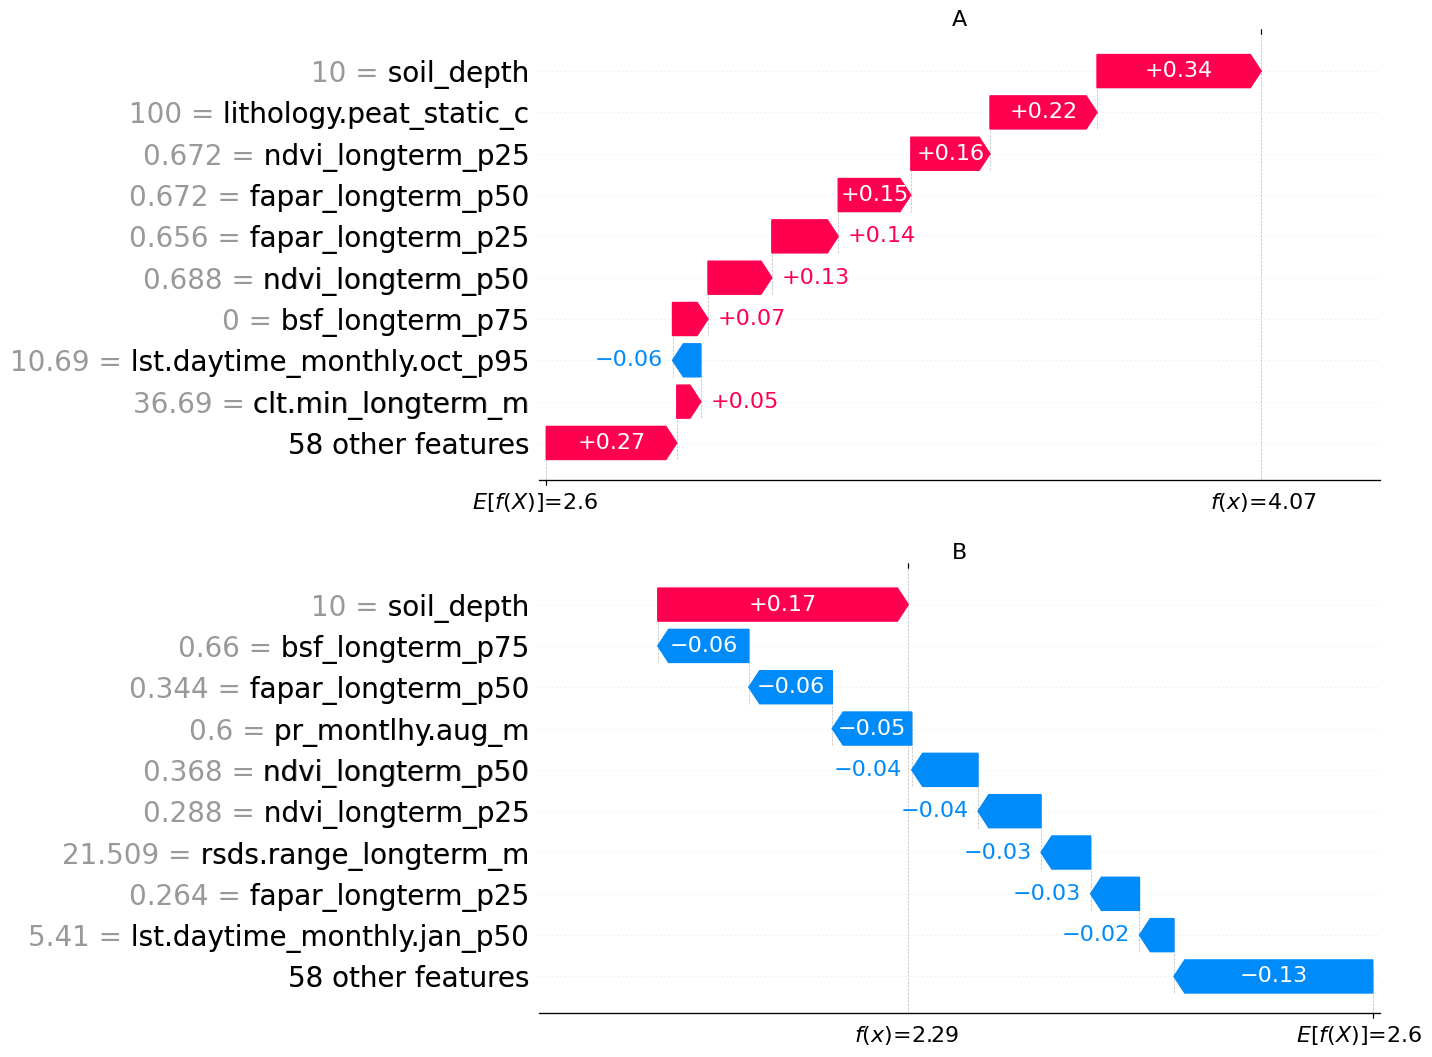

In [12]:
import shap
import matplotlib.pyplot as plt

ept = 2.5980713 #explainer.expected_value[0]
eptt = round(ept, 2)

fig, axes = plt.subplots(2, 1, figsize=(12, 14))  # Adjust the figsize to be larger

plt.sca(axes[0])  # Set the current axis to the first subplot
nuts0 = test.loc[mi[0], 'nuts0']
axes[0].set_title(f"A", fontsize=20)  # Increase title font size
shap.waterfall_plot(shap_values=shaps[mi[0]], max_display=10, show=False)

bse = shaps[mi[0]].values.sum() + ept
bse = round(bse, 2)
axes[0].set_xticks([])  # Remove original xticks
axes[0].text(0.925, -0.05, f"$f(x)$={bse}", fontsize=20, ha='right', va='center', transform=axes[0].transAxes)
axes[0].text(-0.08, -0.05, f"$E[f(X)]$={eptt}", fontsize=20, ha='left', va='center', transform=axes[0].transAxes)

for item in axes[0].get_yticklabels():
    item.set_fontsize(20)
for item in axes[0].get_xticklabels():
    item.set_fontsize(20)

for item in axes[0].get_children():
    if isinstance(item, plt.Text):
        item.set_fontsize(16)
        

plt.sca(axes[1])  # Set the current axis to the second subplot
nuts0 = test.loc[mi[1], 'nuts0']
axes[1].set_title(f"B", fontsize=20)  # Increase title font size
shap.waterfall_plot(shap_values=shaps[mi[1]], max_display=10, show=False)

axes[1].set_xticks([])  # Remove original xticks
bse = shaps[mi[1]].values.sum() + ept
bse = round(bse, 2)
axes[1].text(0.5, -0.05, f"$f(x)$={bse}", fontsize=20, ha='right', va='center', transform=axes[1].transAxes)
axes[1].text(0.9, -0.05, f"$E[f(X)]$={eptt}", fontsize=20, ha='left', va='center', transform=axes[1].transAxes)

for item in axes[1].get_yticklabels():
    item.set_fontsize(20)
for item in axes[1].get_xticklabels():
    item.set_fontsize(20)

for item in axes[1].get_children():
    if isinstance(item, plt.Text):
        item.set_fontsize(16)
        
# for item in axes[1].get_children():
#     if isinstance(item, Text):  # Check if it's a text element
#         item.set_fontsize(20)
#         try:
#             value = float(item.get_text()[1::])
#             print(value)
#             if abs(value) < 0.06:
#                 x, y = item.get_position()
#                 item.set_color("#1f77b4")
#                 item.set_position((x - value, y))  # Shift text to the right (for positive values)
#                 item.set_horizontalalignment("left")  # Align text to the left for clarity

#         except:
#             continue
        
for ax in fig.axes:
    for text in ax.get_xticklabels():
        if "\n$E[f(X)]$" in text.get_text() or "\n$ = " in text.get_text():
            text.set_visible(False)

    for text in ax.get_xticklabels():
        if "$f(x)$" in text.get_text() or "$ = " in text.get_text():
            text.set_visible(False)
            
fig.set_size_inches(14.5, 11)
plt.tight_layout()
plt.savefig(f'{folder_path}/figure/figure_shap.waterfall.svg', format='svg', dpi=300)

plt.show()

# style = {
#     "primary_color_positive": "#ff5733"
# }


In [ ]:
## interaction plot
# shap_interaction_values = explainer.shap_interaction_values(test[covs])
# top10_interaction_values = shap_interaction_values[:, :10, :10]


# sample_indices = np.random.choice(test[covs].index, size=200, replace=False)
# test_sample = test[covs].iloc[sample_indices]

# shap_interaction_values = explainer.shap_interaction_values(test_sample)
# top10_interaction_values = shap_interaction_values[:, :10, :10]


In [ ]:
### individual plot
# import shap
# import matplotlib.pyplot as plt

# # Assume `shap_values` is your SHAP Explanation object
# # Create the SHAP beeswarm plot with `show=False`
# shap.plots.beeswarm(shaps, max_display=16, show=False)

# # Customize the plot
# plt.xlabel("SHAP value \n(impact on model output)", fontsize=20)  # X-axis label size
# # plt.ylabel("Feature", fontsize=20)  # Y-axis label size
# plt.xticks(fontsize=20)  # X-tick size
# plt.yticks(fontsize=20)  # Y-tick size

# # Customize color bar label size if it exists
# cbar = plt.gcf().axes[-1]  # Get the colorbar axis
# cbar.set_ylabel('Feature value', fontsize=20)  # Color bar label size
# cbar.tick_params(labelsize=20)  # Color bar tick size

# # Show the plot
# plt.show()


# import shap
# import matplotlib.pyplot as plt

# # Assume `shap_values` is your SHAP Explanation object
# # Create the SHAP bar plot with `show=False`
# shap.plots.bar(shaps, max_display=10, show=False)

# # Get the current Axes object
# ax = plt.gca()

# # Customize the plot
# ax.set_xlabel("mean(|SHAP value|)", fontsize=20)  # X-axis label size
# # ax.set_ylabel("Feature", fontsize=20)  # Y-axis label size
# ax.set_title("SHAP Feature Importance", fontsize=20)  # Title size

# # Customize tick sizes
# ax.tick_params(axis='both', which='major', labelsize=20)  # X and Y tick size

# for text in ax.texts:
#     text.set_fontsize(20)

# # Show the plot
# plt.show()

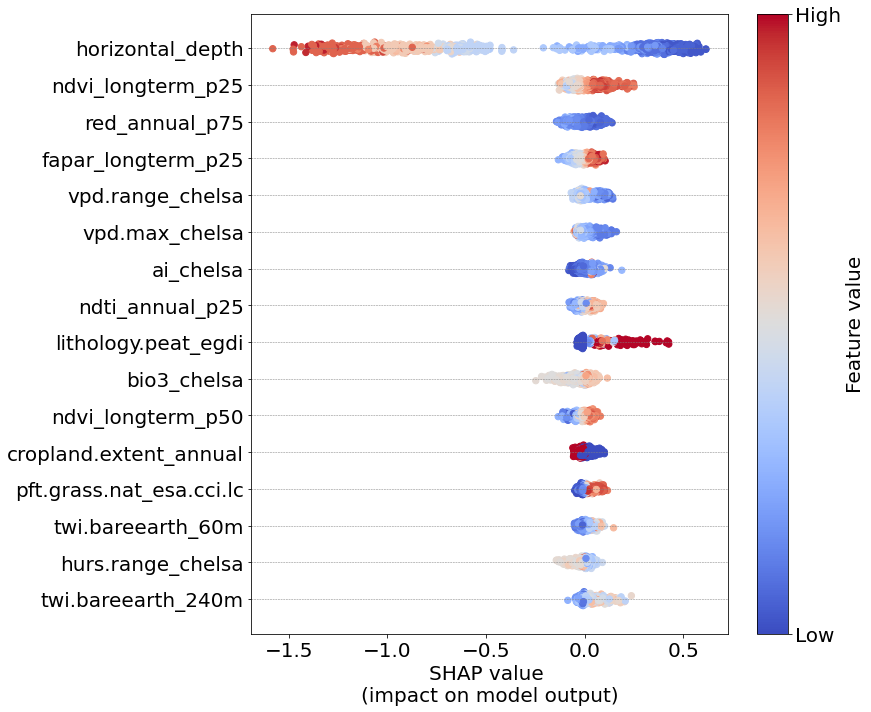

In [ ]:
# ### plot, mimic "shap.plots.bar(shaps, max_display=11)"

# # Step 1: Compute the mean absolute SHAP values for each feature
# mean_abs_shap_values = np.mean(np.abs(shaps.values), axis=0)
# feature_names = shaps.feature_names

# # Step 2: Sort the SHAP values and corresponding features
# sorted_indices = np.argsort(mean_abs_shap_values)[::-1]  # Sort in descending order
# sorted_shap_values = mean_abs_shap_values[sorted_indices]
# sorted_feature_names = np.array(feature_names)[sorted_indices]

# # Step 3: Limit the number of features displayed (e.g., top 16 features)
# max_display = 16
# top_shap_values = sorted_shap_values[:max_display]
# top_feature_names = sorted_feature_names[:max_display]

# # Compute the sum of the remaining features
# sum_of_other_features = np.sum(sorted_shap_values[max_display:])
# top_shap_values = np.append(top_shap_values, sum_of_other_features)
# top_feature_names = np.append(top_feature_names, 'Sum of other features')

# # Step 4: Create a horizontal bar plot with adjustments for axis visibility and text positioning
# fig, ax = plt.subplots(figsize=(10, 9))  # Increased height for better readability

# # Set all bars to blue
# bar_color = 'royalblue'

# # Plot bars
# ax.barh(top_feature_names, top_shap_values, color=bar_color)

# # Adjust the x-limit to ensure text stays within bounds
# ax.set_xlim([0, 1.1 * max(top_shap_values)])

# # Add labels to bars with black text
# for i, value in enumerate(top_shap_values):
#     ax.text(value + 0.01, i, f'{value:.2f}', va='center', fontsize=20, color='black', zorder=5)

# # Make sure x-axis and y-axis lines are visible
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# # Set the left and bottom spines visible for axis lines
# ax.spines['left'].set_visible(True)
# ax.spines['bottom'].set_visible(True)

# # Customize the plot
# ax.set_xlabel('mean(|SHAP value|)', fontsize=20)
# # ax.set_ylabel('Feature', fontsize=20)
# ax.set_title('Top 15 important features', fontsize=22, pad=20)

# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)

# # Reverse the order of features so that the most important feature is at the top
# ax.invert_yaxis()

# # Tight layout for better spacing
# plt.tight_layout()

# # # Save the plot as a high-resolution PDF
# # plt.savefig('custom_shap_bar_plot_v5.pdf', format='pdf', dpi=300)

# # Show plot
# plt.show()


# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# ### mimic "shap.plots.beeswarm(shaps, max_display=16, show=False)"
# # Assuming `shap_values` contains SHAP values and `X` contains the corresponding feature values
# # Extract SHAP values and feature names
# shap_values = shaps.values
# feature_names = shaps.feature_names
# X_values = shaps.data  # Assuming this holds the original feature values used in the model

# # Normalize the feature values to range [0, 1] for color mapping
# normalized_X = (X_values - np.min(X_values, axis=0)) / (np.max(X_values, axis=0) - np.min(X_values, axis=0))

# # Number of features to display
# max_display = 16
# feature_order = np.argsort(np.mean(np.abs(shap_values), axis=0))[::-1][:max_display]
# shap_values = shap_values[:, feature_order]
# normalized_X = normalized_X[:, feature_order]
# feature_names = [feature_names[i] for i in feature_order]

# # Reverse the order to show the most important features at the top
# shap_values = shap_values[:, ::-1]
# normalized_X = normalized_X[:, ::-1]
# feature_names = feature_names[::-1]

# # Create the plot
# fig, ax = plt.subplots(figsize=(12, 10))

# # Choose a color map
# cmap = plt.get_cmap("coolwarm")

# # Plot each feature
# for i, (shap_vals, feature_vals) in enumerate(zip(shap_values.T, normalized_X.T)):
#     # Create a jitter for y positions to simulate the beeswarm effect
#     y = np.random.normal(i, 0.05, size=len(shap_vals))  # Slightly reduced jitter
#     colors = cmap(feature_vals)
#     ax.scatter(shap_vals, y, color=colors, alpha=1, s=40)  # Adjusted transparency and point size
    
# # Set y-ticks to the feature names
# ax.set_yticks(np.arange(len(feature_names)))
# ax.set_yticklabels(feature_names, fontsize=20)  # Y-tick labels font size

# # Set x-label
# ax.set_xlabel("SHAP value \n(impact on model output)", fontsize=20)  # X-label font size

# # Adjust color bar to show 'Low' and 'High'
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_ticks([0, 1])
# cbar.set_ticklabels(['Low', 'High'])
# cbar.set_label("Feature value", fontsize=20)  # Colorbar label font size

# # Set the fontsize for colorbar ticks
# cbar.ax.tick_params(labelsize=20)

# # Add horizontal lines for better readability
# for i in range(len(feature_names)):
#     ax.axhline(y=i, color='grey', linestyle='--', lw=0.5)

# # Adjust tick sizes
# plt.xticks(fontsize=20)  # X-tick font size
# plt.yticks(fontsize=20)  # Y-tick font size

# plt.tight_layout()
# plt.show()

